In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms

from tqdm import tqdm
import random, time, os, sys, json

In [3]:
import dtnnlib as dtnn

In [4]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

## Metrics

In [5]:
def directional_similarity(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=1.5, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+1) ## gives inportance to similarity
    return yout.squeeze(-1)

#### Directional Similarity Based On Gradient Magnitude

In [6]:
def directional_similarity_mag(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
#     print(C.shape)
    C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
#     print(vecs.shape, vecs_mag.shape, C.shape)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [7]:
def directional_similarity_mag_euclidian(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    LP = 2
    vecs = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
#     return 1-vecs_mag.squeeze(-1)
    return 1*torch.norm(direction, dim=-1, keepdim=True)-vecs_mag.squeeze(-1)

In [8]:
def directional_similarity_mag_maximum(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    ## Since the maxima is at 1/2th the distance - direction is doubled to manage
    direction = direction*2
    
    
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
    C = C.unsqueeze(1)
    
    
    vecs = other_points.unsqueeze(0) - (point+direction).unsqueeze(1)
    vecs_mag_from_target = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    
    vecs2 = other_points.unsqueeze(0) - (point).unsqueeze(1)
    vecs_mag = torch.norm(vecs2, p=2, dim=-1, keepdim=True)
    vecs_angle_from_source = vecs2/(vecs_mag+1e-11) ## 1e-B for stability
    
    vecs_mag_from_target = torch.maximum(vecs_mag, vecs_mag_from_target)
    
#     vecs_angle_from_source = torch.acos(vecs_angle_from_source)
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_angle_from_source, direction.unsqueeze(2))## gives importance to direction
    yout = yout/(vecs_mag_from_target+1e-11) ## gives inportance to similarity
#     yout = yout*(vecs_mag_from_target) ## gives inportance to similarity
    yout = yout*C

    return yout.squeeze(-1)

In [9]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[0.5, 0.5]])*1

In [10]:
num_points = 100

C = 1.3
## get dif in point and dirn
px, py = (point+direction*0.5)[0].tolist()
mag = (direction**2).sum().sqrt()

left = px-mag*C
right = px+mag*C
top = py-mag*C
bottom = py+mag*C


X1 = np.linspace(left, right, num_points)
X2 = np.linspace(top, bottom, num_points)
X1, X2 = np.meshgrid(X1, X2)
XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [11]:
# sim = directional_similarity(point, direction, XX_grid)
# sim = directional_similarity_mag(point, direction, XX_grid)
sim = directional_similarity_mag_euclidian(point, direction, XX_grid)
# sim = directional_similarity_mag_maximum(point, direction, XX_grid)
print(sim.max())

tensor(0.7061)


In [12]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([[0.0007, 0.0007]])


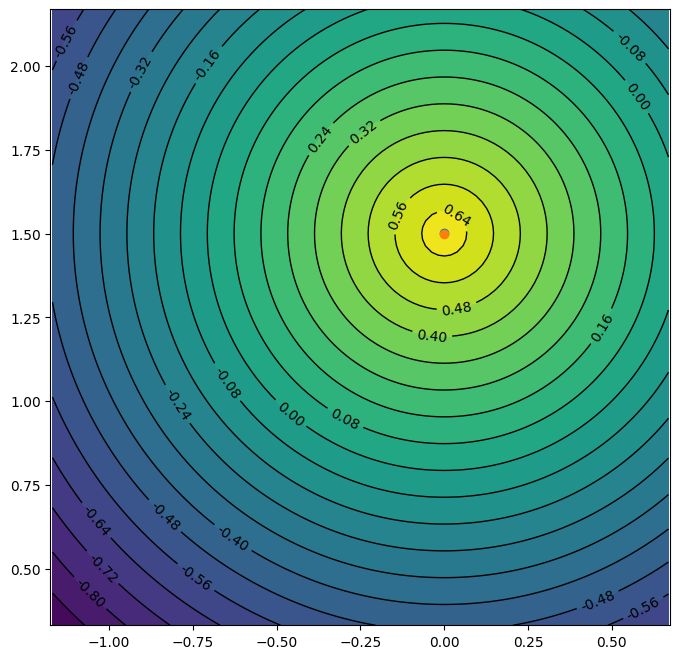

In [13]:
%matplotlib inline
LVLs=20
# LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.scatter(*(point+direction).t())
plt.axis('equal')
print(xx_max-direction-point) ## should give zero for valid maximum


## Device

In [14]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

## For FMNIST dataset

In [15]:
train_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
test_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

train_dataset = datasets.FashionMNIST(root="../../../../_Datasets/FMNIST/", train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root="../../../../_Datasets/FMNIST/", train=False, download=True, transform=test_transform)

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=2)

In [17]:
for xx, yy in train_loader:
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


## Model

In [177]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
            dtnn.DistanceTransform(784, h),
            nn.BatchNorm1d(h),
#             nn.LayerNorm(h, elementwise_affine=False),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=0.0), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 784),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(784, 10)
        
    def forward(self, x):
        bs = x.shape[0]
        x = x.reshape(bs, -1)
        return torch.sigmoid(self.clf(x + self.net(x)))

In [178]:
model = ResidualMLP(20).to(device)
model

ResidualMLP(
  (net): Sequential(
    (0): DistanceTransform()
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): ScaleShift()
      (1): Softmax(dim=-1)
    )
    (3): OneActiv()
    (4): Linear(in_features=20, out_features=784, bias=True)
  )
  (clf): Linear(in_features=784, out_features=10, bias=True)
)

In [179]:
model(torch.randn(2, 1, 28, 28).to(device)).shape

torch.Size([2, 10])

In [180]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  40094


## Training

In [181]:
model = ResidualMLP(20).to(device)

In [182]:
 ## debugging to find the good classifier/output distribution.
model_name = 'dist_tranf_discrete_optim_v0' ## first layer is distance and is selected to input

In [183]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
LR = 0.1

min_sim = 0.00 #-500## 0.0

In [184]:
EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [185]:
valid_points = 1000
train_xx = []

count = 0
for xx, yy in train_loader:
    train_xx.append(xx.reshape(-1, 784))
    count += len(xx)
    if count >= valid_points:
        break
    
train_xx = torch.cat(train_xx, dim=0).to(device)
train_xx.shape

torch.Size([1000, 784])

In [186]:
len(train_loader)

1200

In [187]:
model.net[0].set_centroid_to_data_randomly(train_loader)

In [188]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
prev_idx = torch.ones(model.net[0].centers.data.shape[0], dtype=torch.long).to(device)*-1

def train(epoch, model, optimizer):
    global prev_idx
    
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
#         print(outputs)
#         print(targets)
        
        loss = criterion(outputs, targets)

        loss.backward()
        ########################################################
        ### Do discrete optimization here
        if (batch_idx+0)%3 <= 0:
#             sim = directional_similarity( ## Only direction
#             sim = directional_similarity_mag_euclidian( ## V4 is magnitude
            sim = directional_similarity_mag_maximum( ## V6 is max of-> mag, dirn
                        model.net[0].centers, 
                        -model.net[0].centers.grad * LR, 
                        train_xx)

            ## Method 1 (no filtering)
            if epoch == -1:
                sim_x = sim.argmax(dim=-1)
                model.net[0].centers.data = train_xx[sim_x]
            else:
            ## Method 2 (filtering)
                maxval, maxidx = sim.max(dim=-1)
                valid_mask = maxval > min_sim
                model.net[0].centers.data[valid_mask] = train_xx[maxidx][valid_mask]
#             print(maxidx)
#             print(prev_idx==maxidx)
            

        ########################################################
    #         optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        else:
            model.net[0].centers.grad = None
            optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
#     print("changed: ", torch.count_nonzero(prev_idx!=maxidx))
#     prev_idx = maxidx
    
    loss = train_loss/(batch_idx+1)
    acc = 100.*correct/total
    print(f"[Train] {epoch} Loss: {loss:.3f} | Acc: {acc:.3f} {correct}/{total}")
    return loss, acc

In [189]:
# best_acc = -1
def test(epoch, model, optimizer, best_acc, model_name):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    latency = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            
            start = time.time()
            outputs = model(inputs)
            ttaken = time.time()-start
            
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            latency.append(ttaken)
    
    loss = test_loss/(batch_idx+1)
    acc = 100.*correct/total
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    return loss, acc, best_acc, latency

In [190]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [191]:
# ! mkdir ./models

## Plot Centers

In [192]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_image_grid(image_list, n_row=1):
    image_list = image_list.reshape(-1, 28, 28, 1)
    bs = image_list.shape[0]
    
    n_col = int(np.ceil(bs/n_row))
    
    
    fig = plt.figure(figsize=(2*n_col, 2*n_row))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes
                     )

    for ax, im in zip(grid, image_list):
        ax.imshow(im)
        
    plt.show()

100%|████████████████████████████████████████████████| 1200/1200 [00:03<00:00, 311.95it/s]


[Train] 0 Loss: 1.721 | Acc: 72.207 43324/60000


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 368.34it/s]


[Test] 0 Loss: 1.658 | Acc: 75.180 7518/10000
Saving..


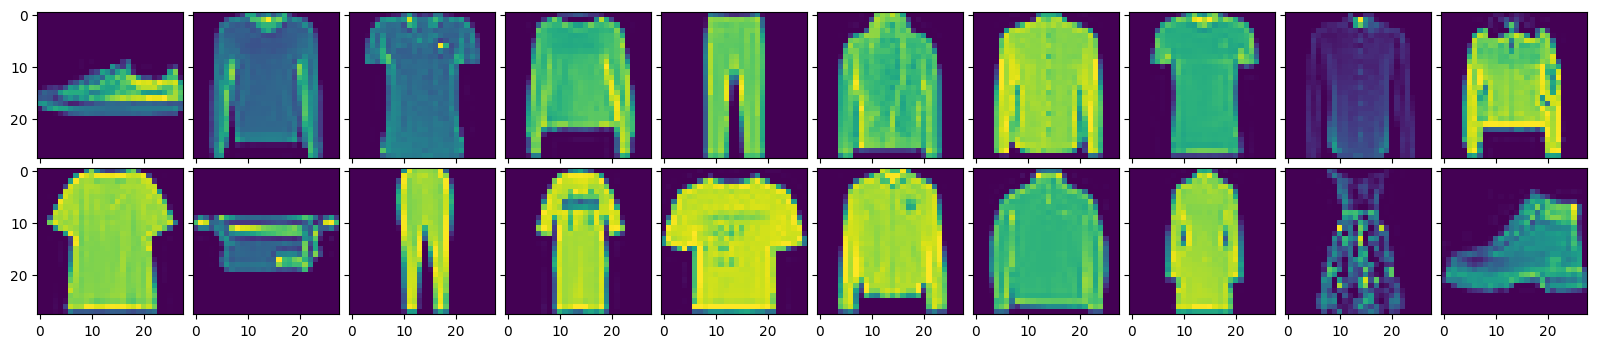

100%|████████████████████████████████████████████████| 1200/1200 [00:03<00:00, 307.09it/s]


[Train] 1 Loss: 1.639 | Acc: 76.798 46079/60000


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 355.16it/s]


[Test] 1 Loss: 1.638 | Acc: 75.500 7550/10000
Saving..


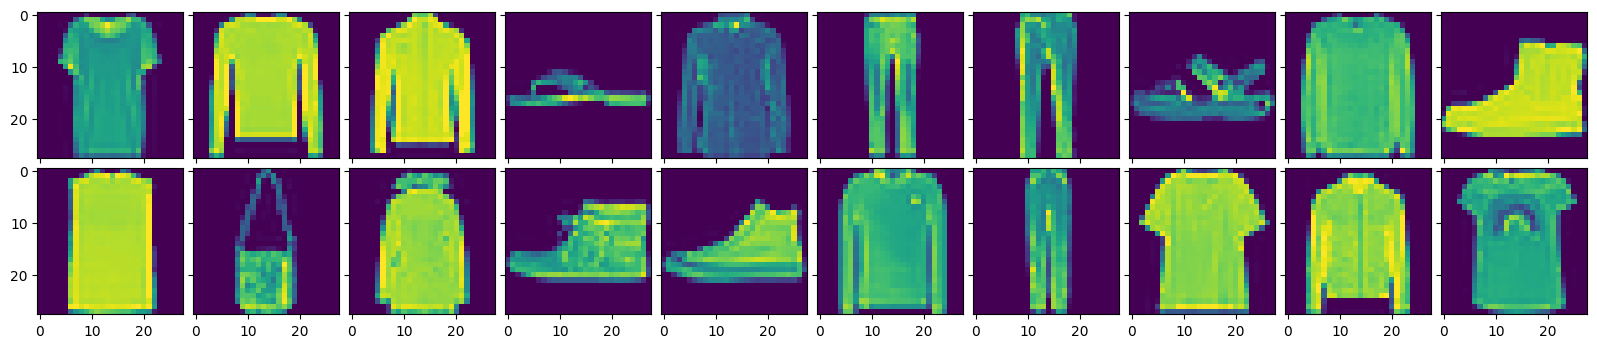

100%|████████████████████████████████████████████████| 1200/1200 [00:03<00:00, 310.12it/s]


[Train] 2 Loss: 1.620 | Acc: 78.103 46862/60000


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 368.92it/s]


[Test] 2 Loss: 1.620 | Acc: 78.800 7880/10000
Saving..


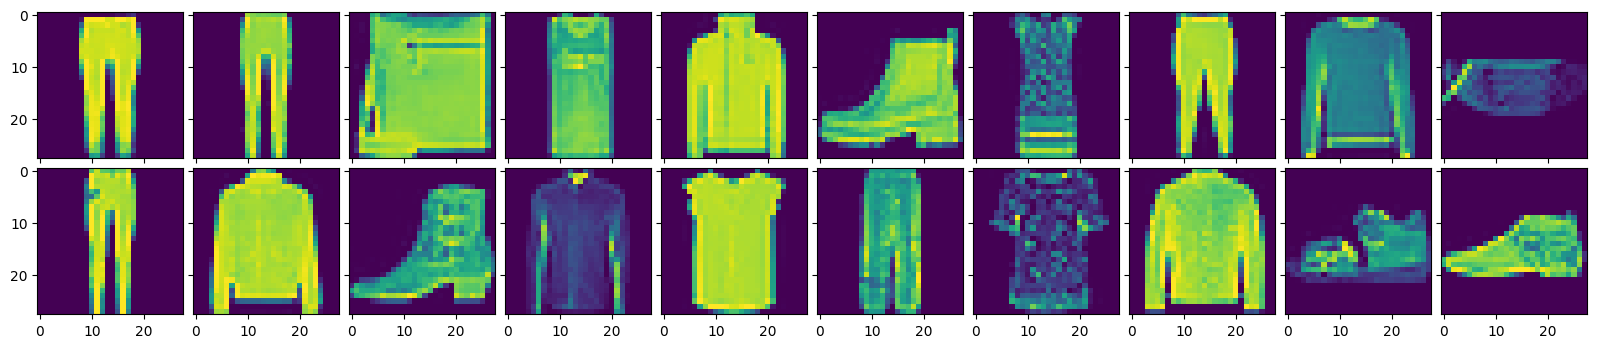

100%|████████████████████████████████████████████████| 1200/1200 [00:03<00:00, 304.05it/s]


[Train] 3 Loss: 1.610 | Acc: 79.490 47694/60000


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 389.72it/s]


[Test] 3 Loss: 1.614 | Acc: 79.610 7961/10000
Saving..


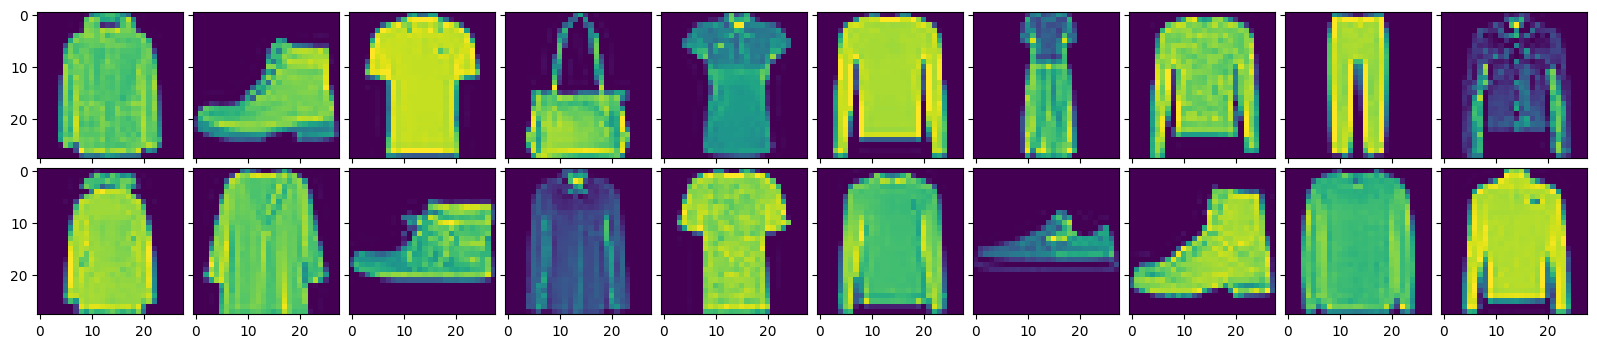

 47%|███████████████████████                          | 565/1200 [00:01<00:02, 300.78it/s]


KeyboardInterrupt: 

In [193]:
# # ### Train the whole damn thing

best_acc = -1
for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    trloss, tracc = train(epoch, model, optimizer)
    teloss, teacc, best_acc, latency = test(epoch, model, optimizer, best_acc, model_name)
#     scheduler.step()
    plot_image_grid(model.net[0].centers.data.cpu(), n_row=2)

In [ ]:
# plot_image_grid(model.net[0].centers.data.cpu())

In [ ]:
asdfsdf

In [ ]:
# best_acc ## 90.42 for ordinary, 89.59 for sparse, 89.82 fro 32bMLP, 